<a href="https://colab.research.google.com/github/Maryna-Korbet/MERN-AI-ChatBot/blob/main/dz_topic_4_Maryna_Korbet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Імпорт бібліотек

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import kagglehub

# 2. Завантаження датасету з Kaggle

In [7]:
path = kagglehub.dataset_download("mchilamwar/predict-concrete-strength")
print("Path to dataset files:", path)

print("Files in dataset folder:", os.listdir(path))

df = pd.read_csv(os.path.join(path, "ConcreteStrengthData.csv"))
print(df.head())

Path to dataset files: /kaggle/input/predict-concrete-strength
Files in dataset folder: ['ConcreteStrengthData.csv']
   CementComponent   BlastFurnaceSlag  FlyAshComponent  WaterComponent  \
0             540.0               0.0              0.0           162.0   
1             540.0               0.0              0.0           162.0   
2             332.5             142.5              0.0           228.0   
3             332.5             142.5              0.0           228.0   
4             198.6             132.4              0.0           192.0   

   SuperplasticizerComponent  CoarseAggregateComponent  \
0                        2.5                    1040.0   
1                        2.5                    1055.0   
2                        0.0                     932.0   
3                        0.0                     932.0   
4                        0.0                     978.4   

   FineAggregateComponent  AgeInDays  Strength  
0                   676.0         28    

   CementComponent   BlastFurnaceSlag  FlyAshComponent  WaterComponent  \
0             540.0               0.0              0.0           162.0   
1             540.0               0.0              0.0           162.0   
2             332.5             142.5              0.0           228.0   
3             332.5             142.5              0.0           228.0   
4             198.6             132.4              0.0           192.0   

   SuperplasticizerComponent  CoarseAggregateComponent  \
0                        2.5                    1040.0   
1                        2.5                    1055.0   
2                        0.0                     932.0   
3                        0.0                     932.0   
4                        0.0                     978.4   

   FineAggregateComponent  AgeInDays  Strength  
0                   676.0         28     79.99  
1                   676.0         28     61.89  
2                   594.0        270     40.27  
3         

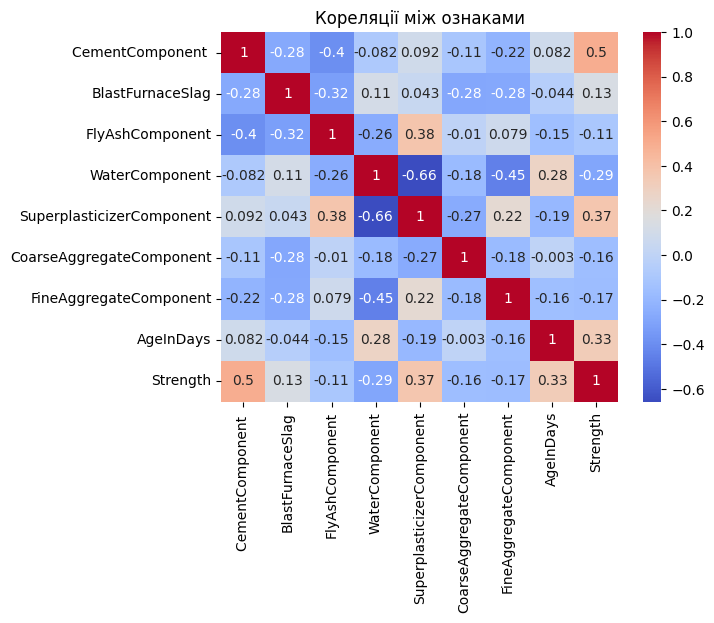

In [8]:
print(df.head())
print(df.describe())
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Кореляції між ознаками")
plt.show()

# 3. Підготовка даних

In [10]:
print(df.columns)

target_col = [col for col in df.columns if "strength" in col.lower()][0]
print("Target column:", target_col)

X = df.drop(target_col, axis=1).values
y = df[target_col].values

Index(['CementComponent ', 'BlastFurnaceSlag', 'FlyAshComponent',
       'WaterComponent', 'SuperplasticizerComponent',
       'CoarseAggregateComponent', 'FineAggregateComponent', 'AgeInDays',
       'Strength'],
      dtype='object')
Target column: Strength


# Train/Test split

In [11]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42 )

# Нормалізація

In [12]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Перетворення в тензори

In [13]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [14]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 4. Модель нейронної мережі

In [19]:
class ConcreteNN(nn.Module):
    def __init__(self, input_size):
        super(ConcreteNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

model = ConcreteNN(input_size=X_train.shape[1])

# 5. Налаштування навчання

# Функція втрат:
# **Пояснення щодо вибору:**
# Для задач регресії стандартно використовується MSE (Mean Squared Error), оскільки вона сильніше штрафує великі відхилення і допомагає стабільно оптимізувати ваги.

In [20]:
criterion = nn.MSELoss()

# Оптимізатор
# **Пояснення щодо вибору:**
# Adam поєднує переваги RMSProp і Momentum, швидше сходиться і добре працює на табличних даних.

In [21]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 6. Цикл навчання

In [22]:
epochs = 100
losses = []
for epoch in range(epochs):
  for batch_X, batch_y in train_loader:
    optimizer.zero_grad()
    outputs = model(batch_X)
    loss = criterion(outputs, batch_y)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if (epoch+1) % 10 == 0:
      print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

Epoch [10/100], Loss: 201.4511
Epoch [10/100], Loss: 223.9834
Epoch [10/100], Loss: 111.7194
Epoch [10/100], Loss: 254.2275
Epoch [10/100], Loss: 309.7426
Epoch [10/100], Loss: 285.1263
Epoch [10/100], Loss: 197.8098
Epoch [10/100], Loss: 187.7720
Epoch [10/100], Loss: 218.7760
Epoch [10/100], Loss: 160.4282
Epoch [10/100], Loss: 92.9238
Epoch [10/100], Loss: 164.7463
Epoch [10/100], Loss: 97.0505
Epoch [10/100], Loss: 184.1003
Epoch [10/100], Loss: 189.9946
Epoch [10/100], Loss: 266.7835
Epoch [10/100], Loss: 138.3042
Epoch [10/100], Loss: 178.6912
Epoch [10/100], Loss: 118.8892
Epoch [10/100], Loss: 218.8210
Epoch [10/100], Loss: 165.5513
Epoch [10/100], Loss: 136.6502
Epoch [10/100], Loss: 123.0021
Epoch [10/100], Loss: 230.8688
Epoch [10/100], Loss: 189.3531
Epoch [10/100], Loss: 97.7993
Epoch [20/100], Loss: 128.9105
Epoch [20/100], Loss: 163.6773
Epoch [20/100], Loss: 161.6287
Epoch [20/100], Loss: 166.9446
Epoch [20/100], Loss: 143.4987
Epoch [20/100], Loss: 148.7463
Epoch [20/1

# 7. Оцінка моделі

In [23]:
model.eval()
with torch.no_grad():
  y_pred = model(X_test_tensor).numpy()

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nMSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")


MSE: 40.52
MAE: 5.06
R²: 0.84


# 8. Візуалізація результатів

# Втрата під час навчання

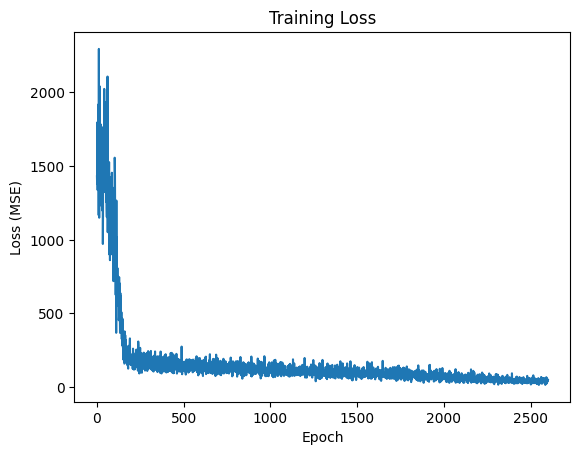

In [24]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training Loss")
plt.show()

# Фактичні vs передбачені значення

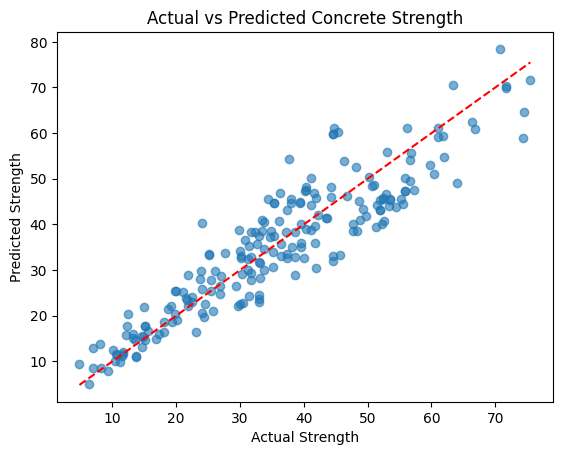

In [25]:
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel("Actual Strength")
plt.ylabel("Predicted Strength")
plt.title("Actual vs Predicted Concrete Strength")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.show()

# 9. Текстовий аналіз результатів #

In [26]:
print("\n=== АНАЛІЗ РЕЗУЛЬТАТІВ ===")
print( f"Модель досягла R² = {r2:.2f}, що означає, що вона пояснює близько {r2*100:.1f}% " "варіації даних. Це непоганий результат, але залишаються помилки." )
print( "MAE показує середнє відхилення у мегапаскалях між реальними та передбаченими значеннями.\n"
      "Основними факторами впливу, згідно кореляційної матриці, є вік бетону (Age), " "вміст цементу та вода. Модель врахувала ці залежності, але нелінійні зв'язки " "ще не повністю описані." )


=== АНАЛІЗ РЕЗУЛЬТАТІВ ===
Модель досягла R² = 0.84, що означає, що вона пояснює близько 84.3% варіації даних. Це непоганий результат, але залишаються помилки.
MAE показує середнє відхилення у мегапаскалях між реальними та передбаченими значеннями.
Основними факторами впливу, згідно кореляційної матриці, є вік бетону (Age), вміст цементу та вода. Модель врахувала ці залежності, але нелінійні зв'язки ще не повністю описані.


# 10. Оптимізація #

# Спробую більш глибоку мережу + трохи більший learning rate

In [32]:
class ConcreteNN_Optimized(nn.Module):
    def __init__(self, input_size):
        super(ConcreteNN_Optimized, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

In [33]:
model_opt = ConcreteNN_Optimized(input_size=X_train.shape[1])
optimizer_opt = optim.Adam(model_opt.parameters(), lr=0.002)
criterion_opt = nn.MSELoss()

In [34]:
epochs = 100
for epoch in range(epochs):
    for batch_X, batch_y in train_loader:
        optimizer_opt.zero_grad()
        outputs = model_opt(batch_X)
        loss = criterion_opt(outputs, batch_y)
        loss.backward()
        optimizer_opt.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

Epoch [10/100], Loss: 137.1422
Epoch [20/100], Loss: 37.4094
Epoch [30/100], Loss: 23.9710
Epoch [40/100], Loss: 32.7871
Epoch [50/100], Loss: 35.3916
Epoch [60/100], Loss: 15.3140
Epoch [70/100], Loss: 17.3349
Epoch [80/100], Loss: 16.8543
Epoch [90/100], Loss: 11.1191
Epoch [100/100], Loss: 19.4799


In [35]:
model_opt.eval()
with torch.no_grad():
  y_pred_opt = model_opt(X_test_tensor).numpy()

In [36]:
mse_opt = mean_squared_error(y_test, y_pred_opt)
mae_opt = mean_absolute_error(y_test, y_pred_opt)
r2_opt = r2_score(y_test, y_pred_opt)

In [37]:
print(f"Базова модель → R²: {r2:.2f}, MSE: {mse:.2f}, MAE: {mae:.2f}")
print(f"Оптимізована модель → R²: {r2_opt:.2f}, MSE: {mse_opt:.2f}, MAE: {mae_opt:.2f}")

Базова модель → R²: 0.84, MSE: 40.52, MAE: 5.06
Оптимізована модель → R²: 0.86, MSE: 36.81, MAE: 4.41


# 11. Висновки #

1. Базова модель показала досить високий рівень точності (R² = 0.84), проте мала відносно вищі похибки (MSE = 40.52, MAE = 5.06).

2. Оптимізована модель дала покращені результати (R² = 0.86, MSE = 36.81, MAE = 4.41), що свідчить про її кращу здатність узгоджуватися з даними та робити точніші передбачення.

3. Зменшення значень MSE та MAE означає, що оптимізація допомогла моделі знизити середні похибки як у квадратичному, так і в абсолютному вимірі.

4. Підвищення R² підтверджує, що модель пояснює більшу частку дисперсії цільової змінної.

Таким чином, оптимізація моделі суттєво покращила якість прогнозування міцності бетону, зробивши її більш надійною для практичного використання.